# Train MOT17 Detections dataset

Train MOT17 detections in SageMaker

### Set up

#### 1. Set  up  accounts and role

In [1]:
import sagemaker
import boto3
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tempfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from skimage import io

sys.path.append('./src')


sagemaker_session = sagemaker.Session()
account_id =  boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name


#role = sagemaker.get_execution_role()
role="arn:aws:iam::{}:role/service-role/AmazonSageMaker-ExecutionRole-20190118T115449".format(account_id)

dataset_url = "https://motchallenge.net/data/MOT17Det.zip"

In [2]:
tmp_dir = "./temp"

#### 2. Setup image and instance type

In [3]:
pytorch_custom_image_name="object-tracking:gpu-1.1.0-202003260645"
instance_type = "ml.p3.2xlarge" 
#instance_type = "local"
docker_repo = "{}.dkr.ecr.{}.amazonaws.com/{}".format(account_id, region, pytorch_custom_image_name)

In [4]:
commit_id =  "5c097b8a5212e3464954711d8288bf9d5526da7c"

#### 3. Configure train/ test and validation datasets

Set prepare dataset to true if you want to download the 5 GB dataset from Mot 17 and update to s3. Once this is in s3 set the prepare_dataset false to avoid redoing this over and over again

In [5]:
prepare_dataset = False

In [6]:
bucket = sagemaker_session.default_bucket()
raw_bucket="aegovansagemaker"

In [7]:
s3_train="s3://{}/mot17Det/train/".format(bucket)


s3_val="s3://{}/mot17Det/val/".format(bucket)

s3_test="s3://{}/mot17Det/test/".format(bucket)



s3_output_path= "s3://{}/mot17det_output/".format(bucket)

checkpoint_s3 = "s3://{}/mot17det_output_checkpoint/run_anchor_mms_20200326/".format(bucket)
localcheckpoint_dir="/opt/ml/checkpoints/"

In [8]:
s3_sample_train="s3://{}/motsample/train/".format(bucket)

s3_sample_val="s3://{}/motsample/val/".format(bucket)



## Visualize image

In [9]:
sample_image = "tests/data/clips/MOT17-11-SDP/img1/000001.jpg"
px, py, w,h = 867,145,236,635
im_w,im_h = 1920, 1080

In [10]:
1920/20*  1080/20

5184.0

In [11]:
image = io.imread(sample_image)
# pre-process data
image = Image.fromarray(image)

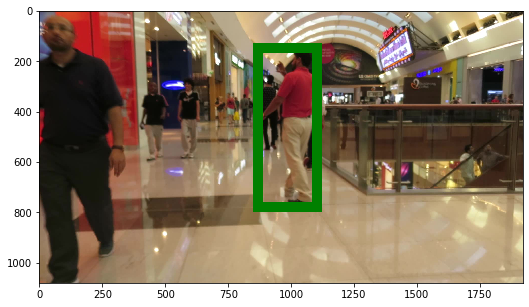

In [12]:


im = np.array(Image.open(sample_image), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1, figsize=(im_w//200,im_h//200))

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((px,py),w,h,linewidth=10,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Make sure image bounding box is resized correctly on image resize

In [13]:
# resize image
ratio=1/20
new_px, new_py, new_w, new_h = px * ratio ,py * ratio, w * ratio, h* ratio

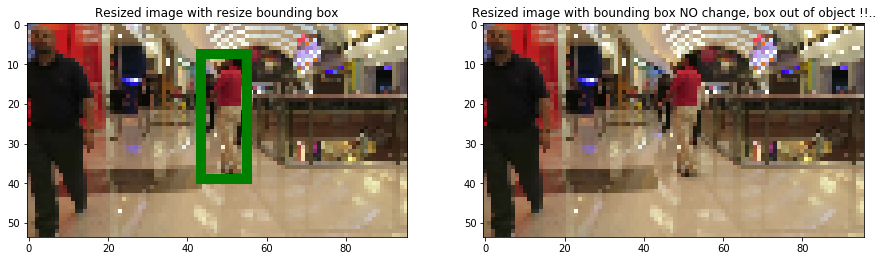

In [14]:


im_small = np.array( Image.open(sample_image).resize((int(im_w * ratio),int(im_h * ratio)) ))


# Create figure and axes
fig,ax = plt.subplots(1,2, figsize=(15,5))


ax[0].imshow(im_small)
rect = patches.Rectangle((new_px ,new_py), new_w, new_h,linewidth=10,edgecolor='g',facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)
ax[0].set_title("Resized image with resize bounding box")




ax[1].imshow(im_small)

rect = patches.Rectangle((px ,py  ),w , h,linewidth=10,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax[1].add_patch(rect)
ax[1].set_title("Resized image with bounding box NO change, box out of object !!..")


plt.show()



### Visualize anchor boxes

In [15]:
# anchor_sizes = ((256,), (128,),(64,), )
# aspect_ratios = ((  2.0,  4.0,  8.0, 12.0),) * len(anchor_sizes)
# colors = ('r', 'b', 'y', "g")

anchor_sizes = ((32,), (64,), (128,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
colors = ('r', 'b', 'y', "g", "m")

ratio = 1/4
new_px, new_py, new_w, new_h = px * ratio ,py * ratio, w * ratio, h* ratio

center_x, center_y = im_w * ratio//2 , im_h * ratio//2


#center_x, center_y = 10,im_h * ratio//2

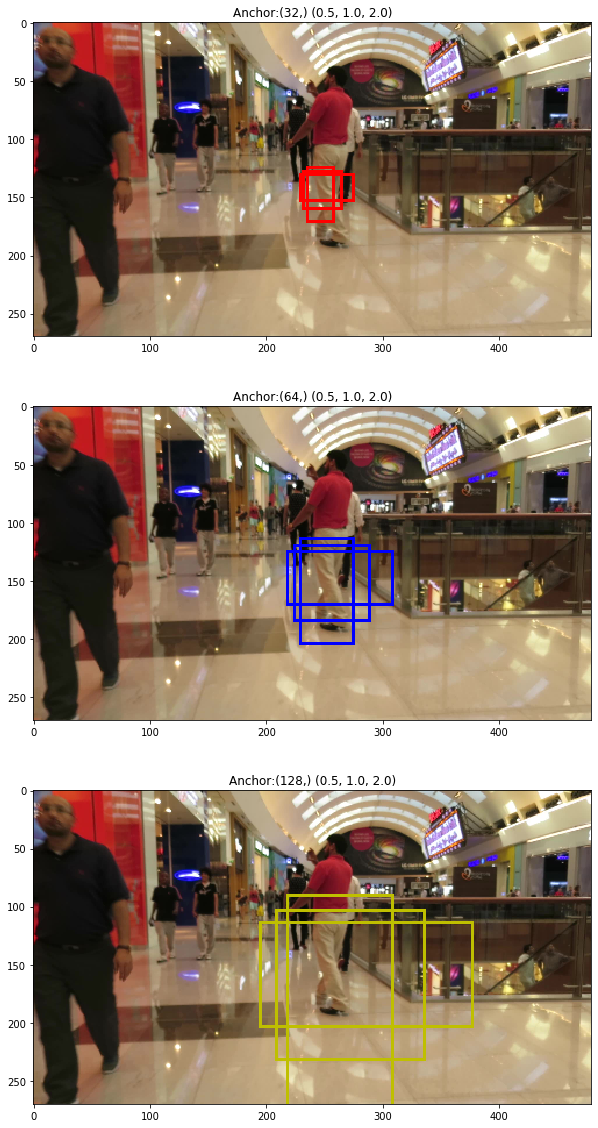

In [16]:

im_small = np.array( Image.open(sample_image).resize((int(im_w * ratio),int(im_h * ratio)) ))



# Create figure and axes
fig,ax = plt.subplots(len(anchor_sizes),1, figsize=(10,20))




from torchvision.models.detection.rpn import AnchorGenerator
import torch


rpn_anchor_generator = AnchorGenerator(
    anchor_sizes, aspect_ratios
)


for i, (sizes, aspect_ratios, c) in enumerate(zip(rpn_anchor_generator.sizes, rpn_anchor_generator.aspect_ratios, colors)):
    rectangles_per_size = rpn_anchor_generator.generate_anchors(
                sizes,
                aspect_ratios
            )
    ax[i].imshow(im_small)
    for r in rectangles_per_size:
        rect = patches.Rectangle((r[0]//2 + center_x,r[1]//2 + center_y), r[2]-r[0] , r[3]-r[1],linewidth=3,edgecolor=c,facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
        ax[i].set_title("Anchor:{} {}".format(sizes, aspect_ratios))
    
    








## Prepare dataset split

In [17]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os
from datetime import datetime

def uploadfile(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """
        #print("Uploading {} to {}".format(localpath, s3path))
        
        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    s3_path = s3_prefix.rstrip("/")
    input_tuples = ( (f, "{}/{}".format( s3_path, f.lstrip(local_dir.lstrip("/")))) for f in glob.glob("{}/**".format(local_dir),  recursive=True) if os.path.isfile(f) )
    list_input_tuples = list(input_tuples)
    print("{} : Uploading {} files".format(datetime.now(), len(list_input_tuples)))
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, list_input_tuples)
    print("{} : upload complete".format(datetime.now(), len(list_input_tuples)))
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size



In [18]:
from sklearn.model_selection import train_test_split
import shutil
def split_train_val(train_dir_root, dest_train, dest_val, dest_test):
    """
    Expects the root path containing MOT 17 directory structure as is. 
    """
    folders = [ (train_dir_root , d)  for d in os.listdir(train_dir_root) if os.path.isdir(os.path.join(train_dir_root, d))]
    train_list, test_list = train_test_split(    folders , test_size=0.2, random_state=42)
    train_list, val_list = train_test_split(    train_list , test_size=0.1, random_state=42)


    def partition(list_to_partition, dest_dir):
        for root, d  in list_to_partition :
            dest_path = os.path.join(dest_dir, d)
            src_path =  os.path.join(train_dir_root, d)
            print("moving {} to {} ".format(src_path, dest_path))
            shutil.move(src_path, dest_path)
            
    partition(train_list, dest_train)
    partition(val_list, dest_val)
    partition(test_list, dest_test)


    

In [19]:
import urllib.request 
from datetime import datetime
import zipfile

def download_dataset(dest_file, url):
    MB = 1024 * 1024 
    read_size= MB * 5
    log_freq=30
    print("Downloading file {}....".format(dest_file))
    with  urllib.request.urlopen(url) as u:
        with open(dest_file, "wb") as o:
            total_read = 0
            i = 0
            while True:
                buffer = u.read(read_size)
                if not buffer:
                    break
                total_read += len(buffer)
                o.write(buffer)
                i += 1
                if i % log_freq == 0 : print("{} so far...{} MB ".format(datetime.now(), total_read/MB))
                

def extract_zip(zip_file, dest_path):
   
    print("Is valid zip file: {}".format(zipfile.is_zipfile(zip_file)))
      
    with zipfile.ZipFile(zip_file) as z:
        print("Invalid members...{}".format(z.testzip()))
        
    with zipfile.ZipFile(zip_file, 'r', allowZip64=True) as z: 
        print("Extracting files to {}....".format(dest_path))
        for member in z.infolist():
            try:
                z.extract(member, dest_path)
            except zipfile.error as e:
                Warning(e)
        print("Completed..")
   

In [20]:
prepare_dataset

False

In [21]:
%%bash -s  "$prepare_dataset" "$dataset_url" "$tmp_dir"

prepare_dataset=$1
dataset_url=$2
download_dir=$3
if [ "$prepare_dataset" == "True" ]
then
    echo  Downloading file $dataset_url to $download_dir
    rm -rf $download_dir
    mkdir -p $download_dir
    wget  -O ${download_dir}/mot17.zip  $dataset_url
    echo  unziping file
    unzip ${download_dir}/mot17.zip -d ${download_dir}/data
fi
echo  "$prepare_dataset"


False


In [22]:
%%time 


if prepare_dataset:
    
    raw_dataset_dir = os.path.join(tmp_dir, "data")
     
    ##NOTE: Do not use python unzip, doesnt seem to extract all file... use bash to download and extract
    #download_dataset(raw_dataset_zip, dataset_url)
    #extract_zip (raw_dataset_zip, raw_dataset_dir )
    
    dest_train = os.path.join(tmp_dir, "train")
    dest_test = os.path.join(tmp_dir, "test")
    dest_val = os.path.join(tmp_dir, "val")
    
    src_raw_train_dir = os.path.join(raw_dataset_dir, "train")
    split_train_val(  src_raw_train_dir  , dest_train, dest_val, dest_test)
    upload_files(dest_train, s3_train)
    upload_files(dest_val, s3_val)
    upload_files(dest_test, s3_test)

else:
    print("Not preparing dataset as prepare_dataset is set to False")

Not preparing dataset as prepare_dataset is set to False
CPU times: user 745 µs, sys: 867 µs, total: 1.61 ms
Wall time: 985 µs


## Start training

In [23]:
inputs = {
    "train" : s3_train,
     "val" :s3_val
}

wait = False


In [24]:
inputs_sample = {
    "train" : s3_sample_train,
     "val" :s3_sample_val
}

if instance_type == 'local':
    inputs = inputs_sample
    wait = True
   # docker_repo = docker_repo.replace(":gpu", ":cpu")

In [25]:
hyperparameters_exp1 = {
    "dataset":"Mot17DetectionFactory",
    "batchsize": "8",
    "epochs" : "1000",
    "learning_rate":.0001,
    "weight_decay":5e-5,
    "momentum":.9,
    "patience": 20,
    "log-level" : "INFO",
    "commit_id":commit_id,
    "model" :"FasterRcnnFactory",
    "accumulation_steps": 8,
    "checkpointdir": localcheckpoint_dir,
     "rpn_pre_nms_top_n_train" : 75,
     "rpn_pre_nms_top_n_test" : 75,
     "rpn_post_nms_top_n_train" : 75,
     "rpn_post_nms_top_n_test" :75
}

In [26]:
metric_definitions = [{"Name": "TrainLoss",
                     "Regex": "###score: train_loss### (\d*[.]?\d*)"}
                    ,{"Name": "ValidationLoss",
                     "Regex": "###score: val_loss### (\d*[.]?\d*)"}
                    ,{"Name": "TrainScore",
                     "Regex": "###score: train_score### (\d*[.]?\d*)"}
                   ,{"Name": "ValidationScore",
                     "Regex": "###score: val_score### (\d*[.]?\d*)"}
                    ,{"Name": "trainVariance",
                     "Regex": "###score: train_loss_std### (\d*[.]?\d*)"}
                    ,{"Name": "ValVariance",
                     "Regex": "###score: val_loss_std### (\d*[.]?\d*)"}
                    ]

In [27]:
# set if you need spot instance
use_spot = True
train_max_run_secs =   2*24 * 60 * 60
spot_wait_sec =  5 * 60
max_wait_time_secs = train_max_run_secs +  spot_wait_sec


# During local mode, no spot..
if instance_type == 'local':
    use_spot = False
    max_wait_time_secs = 0

In [28]:
!git log -1| head -1
!git log -1| tail -1

commit 111c33470f66edf0c8eec36855f2f9e650dd18dc
    Update notebook - Fix image version


In [29]:
hyperparameters = hyperparameters_exp1


In [30]:
hyperparameters

{'dataset': 'Mot17DetectionFactory',
 'batchsize': '8',
 'epochs': '1000',
 'learning_rate': 0.0001,
 'weight_decay': 5e-05,
 'momentum': 0.9,
 'patience': 20,
 'log-level': 'INFO',
 'commit_id': '5c097b8a5212e3464954711d8288bf9d5526da7c',
 'model': 'FasterRcnnFactory',
 'accumulation_steps': 8,
 'checkpointdir': '/opt/ml/checkpoints/',
 'rpn_pre_nms_top_n_train': 75,
 'rpn_pre_nms_top_n_test': 75,
 'rpn_post_nms_top_n_train': 75,
 'rpn_post_nms_top_n_test': 75}

In [31]:
git_config = {'repo': 'https://github.com/elangovana/object-tracking.git',
              'branch': 'master',
              'commit': hyperparameters['commit_id']
             }

In [32]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
     entry_point='experiment_train.py',
                    source_dir = 'src',
                    dependencies =['src/detection_datasets', 'src/evaluators', 'src/models'],
                    role=role,
                    framework_version ="1.0.0",
                    py_version='py3',
                    git_config= git_config,
                    image_name= docker_repo,
                    train_instance_count=1,
                    train_instance_type=instance_type,
                    hyperparameters =hyperparameters,
                    output_path=s3_output_path,
                    metric_definitions=metric_definitions,
                    train_use_spot_instances = use_spot,
                    train_max_run =  train_max_run_secs,
                    train_max_wait = max_wait_time_secs,   
                    base_job_name ="object-detection",
                    checkpoint_s3_uri=checkpoint_s3,
                    checkpoint_local_path=localcheckpoint_dir)

In [ ]:
estimator.fit(inputs, wait=wait)